
# A demo of K-Means clustering on the handwritten digits data

In this example we compare the various initialization strategies for K-means in
terms of runtime and quality of the results.

As the ground truth is known here, we also apply different cluster quality
metrics to judge the goodness of fit of the cluster labels to the ground truth.

Cluster quality metrics evaluated (see `clustering_evaluation` for
definitions and discussions of the metrics):

=========== ========================================================
Shorthand    full name
=========== ========================================================
homo         homogeneity score
compl        completeness score
v-meas       V measure
ARI          adjusted Rand index
AMI          adjusted mutual information
silhouette   silhouette coefficient
=========== ========================================================


## Load the dataset

We will start by loading the `digits` dataset. This dataset contains
handwritten digits from 0 to 9. In the context of clustering, one would like
to group images such that the handwritten digits on the image are the same.



In [3]:
import numpy as np

from sklearn.datasets import load_digits

#return_X_y=True specifies that the function should return both data (images of digits) and labels
data, labels = load_digits(return_X_y=True)
#extracts (number of samples, number of features per sample), number of unique digit labels
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to
compare different initialization methods for KMeans. Our benchmark will:

* create a pipeline which will scale the data using a
  :class:`~sklearn.preprocessing.StandardScaler`;
* train and time the pipeline fitting;
* measure the performance of the clustering obtained via different metrics.



In [4]:
from time import time

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    #start clock to know how long each Kmeans strategy/fitting process takes.
    t0 = time()
    # Make_Pipeline: Useful for when when we want to perform operations step by step on data, we can make a pipeline of all the estimators in sequence.
    # This pipeline scales the data using StandardScaler(), and then applied the kmeans clustering algorithm. 
    # StandardScaler() Standardizes features by making the mean 0 and scaling to unit variance. Subtracts mean value and divides by std to make std 1. 
    # Unit variance: Unit variance means that the standard deviation of a sample as well as the variance will tend towards 1 as the sample size tends towards infinity.
    #'fit' method is called to fit the model to the input data. Trains the algorithm on the data once it is initiatilized.
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    # See how long it took to fit kmeans model.
    fit_time = time() - t0
    # Creates results array that contains strategy name, fit time, and the inertia (a measure of how spread out the clusters are) of the fitted KMeans model).
    # Inertia =  It represents the sum of squared distances of samples to their closest cluster center. Goal is to minimize this value.
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    #defines list of metrics to quantify kmeans model.
    clustering_metrics = [
        # Assesses how well the clusters formed by the algorithm correspond to the true classes (if its clusters contain only data points which are members of a single class). The score ranges from 0 to 1, where 1 indicates perfect homogeneity. 
        # A high homogeneity score means that each cluster predominantly contains data points from a single true class. 
        # A low homogeneity score suggests that the clusters are mixed with data points from different true classes.
        metrics.homogeneity_score,
        #assesses how well the clusters formed by the algorithm capture entire classes. The score also ranges from 0 to 1, where 1 indicates perfect completeness.
        # A high completeness score means that all data points from the same true class are assigned to the same cluster.
        # A low completeness score suggests that some members of the same true class are assigned to different clusters.
        metrics.completeness_score,
        # a harmonic mean of homogeneity and completeness. This metric is useful when you want to consider both precision (homogeneity) and recall (completeness).
        # V-Measure score is computed using the harmonic mean of homogeneity and completeness. The score ranges from 0 to 1, where 1 indicates a perfect balance between homogeneity and completeness.
        # A high V-Measure score implies that the clustering algorithm achieves both high homogeneity and completeness.
        # A low V-Measure score suggests an imbalance between homogeneity and completeness.
        metrics.v_measure_score,
        # Computes the agreement between pairs of data points based on whether they are in the same cluster in both the true and predicted labelings. 
        # Adjusts the raw Rand index by considering the expected similarity due to chance.
        metrics.adjusted_rand_score,
        # Measure of the similarity between two labels of the same data.
        metrics.adjusted_mutual_info_score,
    ]
    # Computes metrics using given labels and labels predicted by model (estimator[-1].labels_) for each metric. Appends value to results.
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset, computed separately. Quantifies inter-cluster proximity and intra-cluster distance.
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

## Run the benchmark

We will compare three approaches:

* an initialization using `k-means++`. This method is stochastic and we will
  run the initialization 4 times;
* a random initialization. This method is stochastic as well and we will run
  the initialization 4 times;
* an initialization based on a :class:`~sklearn.decomposition.PCA`
  projection. Indeed, we will use the components of the
  :class:`~sklearn.decomposition.PCA` to initialize KMeans. This method is
  deterministic and a single initialization suffice.



In [5]:
"""Stochastic vs Deterministic
Deterministic: produce the same exact results for a particular set of inputs
Stochastic: Have random variables. Best for data that has degree of randomness.
"""

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

"""Creates a kmeans instance with:
    k-means++ initialization: 
        the first centroid is randomly chosen from the data points, and subsequent centroids are
        chosen with a probability distribution proportional to the squared distance from the point 
        to the nearest existing centroid. (Select the next centroid from the data points such that the probability of choosing 
        a point as centroid is directly proportional to its distance from the nearest, previously chosen 
        centroid. (i.e. the point having maximum distance from the nearest centroid is most 
        likely to be selected next as a centroid)
        This method aims to spread out the initial centroids, often
        leading to faster convergence and more accurate results.
    number of clusters is the number of digits,
    n_init Specifies the number of times the KMeans algorithm will be run with different centroids. The final result will be the best output in terms of inertia.
    random_state: seed the random number generator when initializing the centroids so the same random numbers are produced each time.
""" 
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
# Calculate all metrics for the given kmeans instance. 
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

"""Creates a Kmeans instance with: 
    random initial centroids:  The initial centroids are selected by randomly choosing k data points from the dataset
"""
kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

"""Creates a Kmeans instance with:
    Principal Component Analysis: 
        a dimensionality reduction technique used to transform high-dimensional data into a lower-dimensional 
        representation while preserving the most important information.
    Initial cluster centroids will be set as PCA results, transformed data from 64-D space to 10-D space.
"""
pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.242s	69545	0.598	0.645	0.621	0.469	0.617	0.153
random   	0.370s	69735	0.681	0.723	0.701	0.574	0.698	0.178
PCA-based	0.032s	72686	0.636	0.658	0.647	0.521	0.643	0.134
__________________________________________________________________________________


## Visualize the results on PCA-reduced data

:class:`~sklearn.decomposition.PCA` allows to project the data from the
original 64-dimensional space into a lower dimensional space. Subsequently,
we can use :class:`~sklearn.decomposition.PCA` to project into a
2-dimensional space and plot the data and the clusters in this new space.



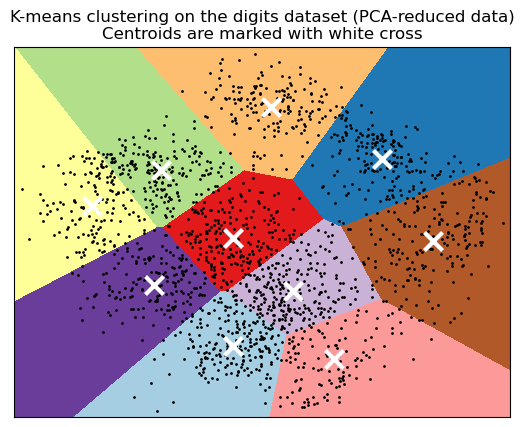

In [6]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
#Run kmeans on 2D data. 
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
# Defines a meshgrid (xx and yy) that covers the range of the reduced data.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
#Plots different kmeans centroid areas. 
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)
#Plots data points
plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()